## Livrable 3

## Captioning


(Lien avec le livrable 1 ???)

### Groupe de projet :
- Rémi Papin
- Fabien Richard
- Zacharia Azzouzi
<br>
<br>

### Introduction




## Import

L'ensemble des imports des bibliothèques pour mener à bien ce projet.

In [1]:
# %pip install opencv-python

In [2]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
import configuration
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import datetime
import pathlib
from tensorboard.plugins.hparams import api as hp
from skimage.util import random_noise
%matplotlib inline

data_dir = configuration.data_dir

## Datasets

Le script qui suit utilise toutes les images du dataset original pour générer un dataset équivalent d'image bruitée.

In [3]:
#Comment this if you are sure thath= you want generate noisy dataset
#Check if there is already img in noise directory
if len(os.listdir(data_dir+"/noise")) == 0:
    print("Generating noise images")
    for file in os.listdir(data_dir+"/clean"):
        # Load the image
        image = cv2.imread(os.path.join(data_dir+"/clean",file))
        if image is not None:
            # Add salt-and-pepper noise to the image
            noise = random_noise(image, mode='s&p', amount=0.03+(random.random()*0.5))

            # The above function returns a floating-point image in the range [0, 1]
            # so need to change it to 'uint8' with range [0,255]
            noise = np.array(255 * noise, dtype=np.uint8)
            cv2.imwrite(os.path.join(data_dir+"/noise",file),noise)
        #break # Uncomment to test the noisification on the first image only

Le script qui suit charge le dataset tout en appliquant une pipeline dessus pour unifier le format des données. Le pipeline consiste à redimensionner les images selon les variables ``ìmage_h`` et ``image_w``, à passer les valeurs, qui sont originelement entre 0 et 255, entre 0 et 1 et à mélanger les images.
Les deux set d'images ("clean_img" et "noisy_img") sont mélangés en même temps pour garder la correspondance des index des images.

In [4]:
image_h = 512
image_w = 512
batch_s = 5
dataset_size = 50
epochs=80

validation_threshold=0.2

normalization_layer = tf.keras.layers.Rescaling(1./255)
flattend_layer = tf.keras.layers.Flatten()

valid_images = [".jpg",".gif",".png"]

# shuffle_in_unison can shuffle two array and keep index relations
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

clean_set = []
noisy_set = []
# we are loading only 100 image to speed up the process
while len(clean_set) < dataset_size:
    index_img = random.randint(0, len(os.listdir(data_dir+"/noise")))
    file = os.listdir(data_dir+"/clean")[index_img]
    ext = os.path.splitext(file)[1]
    if ext.lower() not in valid_images or not os.path.isfile(os.path.join(data_dir+"/noise",file)) :
        continue
    clean_img=cv2.imread(os.path.join(data_dir+"/clean",file))
    clean_img=cv2.resize(clean_img, (image_h, image_w))
    clean_img=clean_img.astype('float32') / 255.

    noisy_img=cv2.imread(os.path.join(data_dir+"/noise",file))
    noisy_img=cv2.resize(noisy_img, (image_h, image_w))
    noisy_img=noisy_img.astype('float32') / 255.

    clean_set.append(clean_img)
    noisy_set.append(noisy_img)

clean_set = np.array(clean_set, dtype=object)
noisy_set = np.array(noisy_set, dtype=object)
(clean_set, noisy_set)=shuffle_in_unison(clean_set, noisy_set)

split_index=int(noisy_set.shape[0]*(1-validation_threshold))

(clean_train_set, clean_test_set)=np.split(clean_set, [split_index])
(noisy_train_set, noisy_test_set)=np.split(noisy_set, [split_index])

print("Found {:d} clean files, {:d} train / {:d} test".format(clean_set.shape[0], clean_train_set.shape[0], clean_test_set.shape[0]))
print("Found {:d} noisy files, {:d} train / {:d} test".format(noisy_set.shape[0], noisy_train_set.shape[0], noisy_test_set.shape[0]))

Found 50 clean files, 40 train / 10 test
Found 50 noisy files, 40 train / 10 test


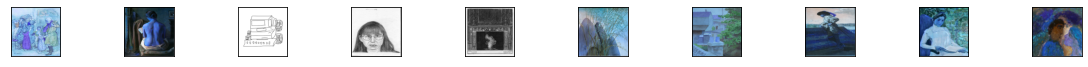

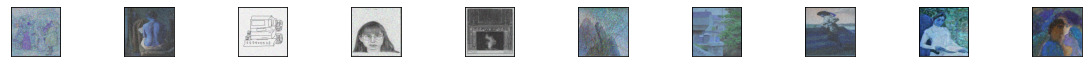

In [5]:
def display_image(X, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].astype('float32'))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_image(clean_train_set, n=10)
display_image(noisy_train_set, n=10)

On peut observer les images originales sur la première ligne et les images bruitées corerspondantes en dessous. Pour l'entrainement, les labels sont les images elles-mêmes.

## Construction du modèle
Pour réaliser ce modèle nous avons créé une architecture reposant sur plusieurs couches :

- Une layers Input
- Plusieurs couches en fonction du paramètre ``filters`` (encodeur) :
    - Une layers Conv2D
    - Une layers MaxPooling2D
- Plusieurs couches en fonction du paramètre ``filters`` (décodeur) :
    - Une layers Conv2D
    - Une layers UpSampling2D
- Une layers Conv2D


In [6]:
def build_autoencoder(height, width, depth, filters=(32, 64)):
    # initialize the input shape to be "channels last" along with
    # the channels dimension itself
    # channels dimension itself
    inputShape = (height, width, depth)
    chanDim = -1
    # define the input to the encoder
    inputs = layers.Input(shape=inputShape)
    x = inputs
    # loop over the number of filters
    for f in filters:
        # apply a CONV => MAX_POOLING
        x = layers.Conv2D(filters=f, kernel_size=(3, 3), activation='relu', padding="same")(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        
    # loop over our number of filters again, but this time in
    # reverse order
    for f in filters[::-1]:
        # apply a CONV => UP_SAMPLING
        x = layers.Conv2D(filters=f, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    # our autoencoder is the encoder + decoder
    autoencoder = keras.models.Model(inputs, x,
        name="autoencoder")
    # return a 2-tuple of the input and autoencoder
    return (inputs, autoencoder)


(encoder_inputs, autoencoder) = build_autoencoder(image_h, image_w, 3, filters=(16, 32, 64))

# Résumé du modèle
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      

### Checkpoint

Pour ne pas perdre du temps à ré entrainer les models à chaque fois nous réalisons des checkpoints nous permettant de conserver les valeurs de notre modèle le plus performant. 

In [7]:
# Prepare for model checkpoints
checkpoint_path = "training/cp_autoencoder_{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='min')

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 16,
    'dropout': 0.2
})

### Entrainement du modèle

Nous compilons notre modèle avec l'optimiseur ``adam`` et nous récupérons la loss à l'aide de la ``binary_crossentropy``.

In [8]:
# Compiler le modèle
autoencoder.compile(optimizer="adam",loss= 'binary_crossentropy')

Epoch 1/80
8/8 [==============================] - ETA: 0s - loss: 0.6793
Epoch 00001: val_loss improved from inf to 0.62587, saving model to training\cp_autoencoder_01.ckpt
8/8 [==============================] - 18s 2s/step - loss: 0.6793 - val_loss: 0.6259
Epoch 2/80
8/8 [==============================] - ETA: 0s - loss: 0.6338
Epoch 00002: val_loss improved from 0.62587 to 0.56100, saving model to training\cp_autoencoder_02.ckpt
8/8 [==============================] - 16s 2s/step - loss: 0.6338 - val_loss: 0.5610
Epoch 3/80
8/8 [==============================] - ETA: 0s - loss: 0.5939
Epoch 00003: val_loss improved from 0.56100 to 0.51884, saving model to training\cp_autoencoder_03.ckpt
8/8 [==============================] - 16s 2s/step - loss: 0.5939 - val_loss: 0.5188
Epoch 4/80
8/8 [==============================] - ETA: 0s - loss: 0.5512
Epoch 00004: val_loss improved from 0.51884 to 0.49959, saving model to training\cp_autoencoder_04.ckpt
8/8 [==============================] - 16

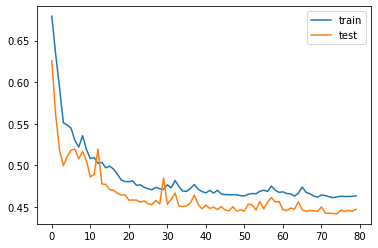

In [9]:


# Exécution du modèle
history = autoencoder.fit(tf.convert_to_tensor(noisy_train_set, dtype=tf.float32), tf.convert_to_tensor(clean_train_set, dtype=tf.float32),
                          epochs=epochs, batch_size=batch_s,
                          shuffle=True,
                          validation_data=(tf.convert_to_tensor(noisy_test_set, dtype=tf.float32), tf.convert_to_tensor(clean_test_set, dtype=tf.float32)),
                          callbacks=[cp_callback,tensorboard_callback])
 

# Save the model
save_path = "checkpoints/"+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+".ckpt"
autoencoder.save_weights(save_path)

# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot( history.history['loss'],
         label='train')
plt.plot( history.history['val_loss'],
         label='test')
plt.legend()

Nous pouvons observer sur le graphique précédent une diminution de la loss au fil des epochs pour le jeu d'entrainement et aussi pour le jeu de test, ce qui montre que notre modèle apprend des choses.

Le code qui suit va utiliser notre modèle entrainé pour enlever le bruit d'images bruitées passées en paramètres.

In [10]:
decoded_imgs = autoencoder.predict(tf.convert_to_tensor(noisy_test_set, dtype=tf.float32))

La première ligne correspond à la sortie du modèle, la seconde ligne correspond à l'image bruitée passée en entré et la dernière ligne correspond à l'image original.

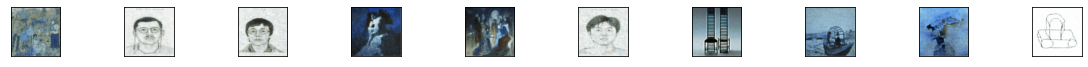

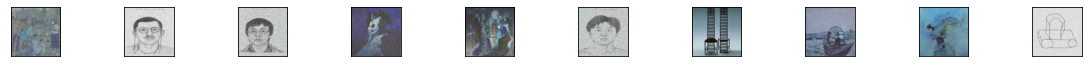

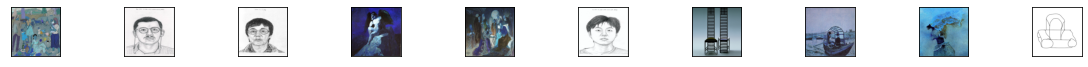

In [11]:
display_image(decoded_imgs, 10)
display_image(noisy_test_set, 10)
display_image(clean_test_set, 10)

In [12]:
!tensorboard dev upload --logdir ./logs \
  --name "Livrable 2 : Projet Datascience - Leyenda." \
  --description "Modèle autoencodeur de débruitage." \
  --one_shot

2022-01-05 10:57:49.835979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/CJBdEmZtR0aNRT1fZS0AkA/

[2022-01-05T10:57:59] Started scanning logdir.
Data upload starting...
Uploading binary object (63.0 kB)...
Uploading 691 tensors (496.7 kB)...
Uploading 691 tensors (496.7 kB)...
Uploading binary object (63.0 kB)...
Uploading 691 tensors (496.7 kB)...
Uploading binary object (63.3 kB)...
Uploading 691 tensors (496.7 kB)...
Uploading binary object (63.4 kB)...
Uploading binary object (63.0 kB)...
Uploading 690 tensors (496.0 kB)...
Uploading 843 scalars...
Uploading 480 tensors (344.5 kB)...
[2022-01-05T10:58:07] Total uploaded: 843 scalars, 3934 tensors (2.8 MB), 5 binary objects (315.6 kB)
[2022-01-05T10:58:07] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/CJBdEmZtR0aNRT1fZS0AkA/



2022-01-05 10:57:49.836020: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-05 10:57:57.815369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-01-05 10:57:57.816491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2022-01-05 10:57:57.817581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2022-01-05 10:57:57.818646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cufft64_10.dll'; dlerror: cufft64_10.dll not found
2022-01-05 10:57:57.819707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'curan

## Schématisation de notre modèle et explication des couches

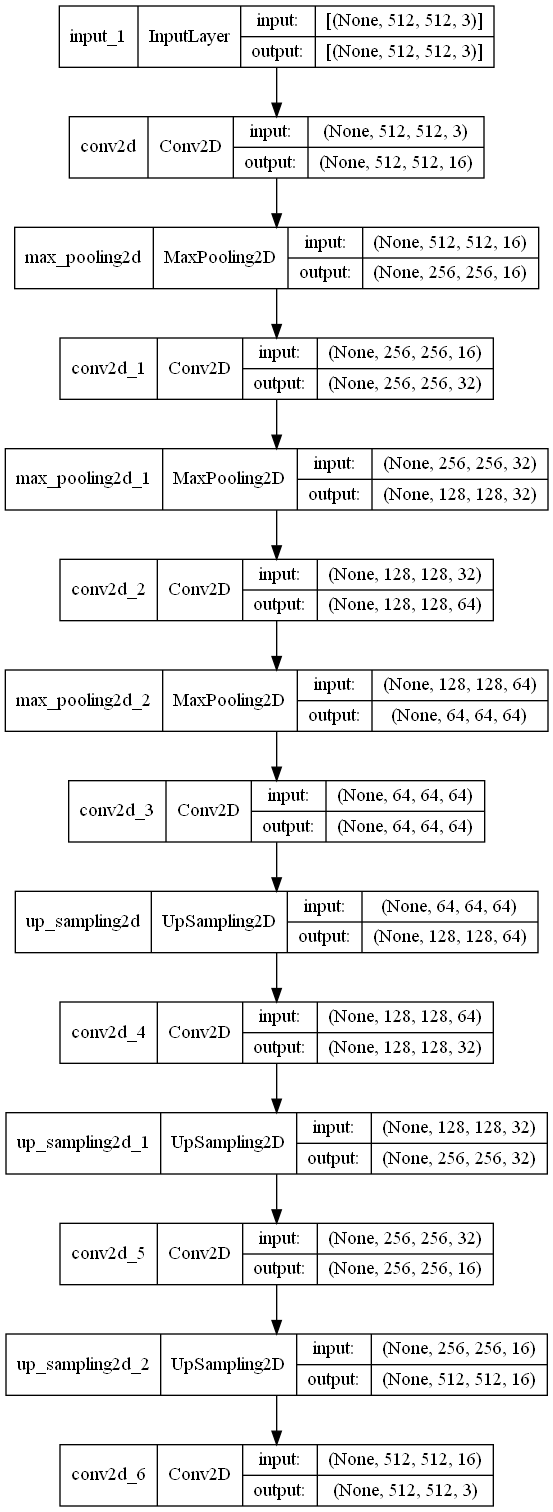

In [13]:
tf.keras.utils.plot_model(
autoencoder, to_file='model_auto_encodeur.png', show_shapes=True, show_dtype=False,
show_layer_names=True, expand_nested=True, dpi=96
)